# Data analysis of NYC4x4 data

# Imports and data loading

In [1]:
import os
os.chdir("..")

In [2]:
import multi_agent_reinforcement_learning
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf

In [3]:
with open("data/scenario_nyc4x4.json") as f:
    data = json.loads(f.read())

In [4]:
df = pd.DataFrame(data["demand"])

In [5]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,0,5,5,0.6,4.105556,6.5
1,1,5,5,0.6,4.105556,6.5
2,2,5,5,0.6,4.105556,6.5
3,3,5,5,0.6,4.105556,6.5
4,4,5,5,0.6,4.105556,6.5


# Simple summary stats

In [6]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [7]:
df_org_dest.head()

origin destination price              demand travel_time
                     count      mean      mean        mean
0      0           0  1320  7.418935  0.194697    5.098273
1      0           1  1230  6.432661  0.235772    4.174467
2      0           2  1260  7.594516  0.326984    5.456276
3      0           3  1245  9.239509  0.224096    7.088674
4      0           4  1335  7.739372  0.330337    6.533852

In [8]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["org", "dest", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [9]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,281760.000000,281760.000000,281760.000000,281760.000000,281760.000000,281760.000000
mean,784.571603,7.243239,7.332836,0.368732,8.596823,9.384479
std,397.244680,4.360040,4.401259,0.378120,4.375876,3.188406
min,0.000000,0.000000,0.000000,0.066667,0.000000,3.000000
25%,489.000000,4.000000,4.000000,0.133333,5.539722,7.405417
50%,804.000000,7.000000,7.000000,0.266667,7.904167,8.930000
75%,1122.000000,11.000000,11.000000,0.466667,10.877976,10.800000
max,1439.000000,15.000000,15.000000,4.200000,110.000000,95.350000


# Grid analysis

In [10]:
pivot_df = df_org_dest.pivot(index='org', columns='dest', values='count')

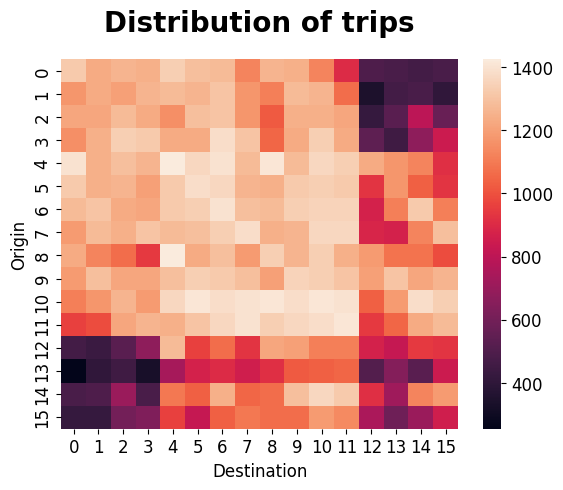

In [11]:
sns.heatmap(pivot_df, annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel('Destination')
plt.ylabel('Origin')
plt.show()

In [12]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(4,4)

In [13]:
mean_demand_matrix

array([[0.23968542, 0.26703533, 0.33333333, 0.30472934],
       [0.49045177, 0.4487395 , 0.5896938 , 0.51190658],
       [0.32081031, 0.55352043, 0.4433069 , 0.41764259],
       [0.1620227 , 0.13862434, 0.18612717, 0.16527934]])

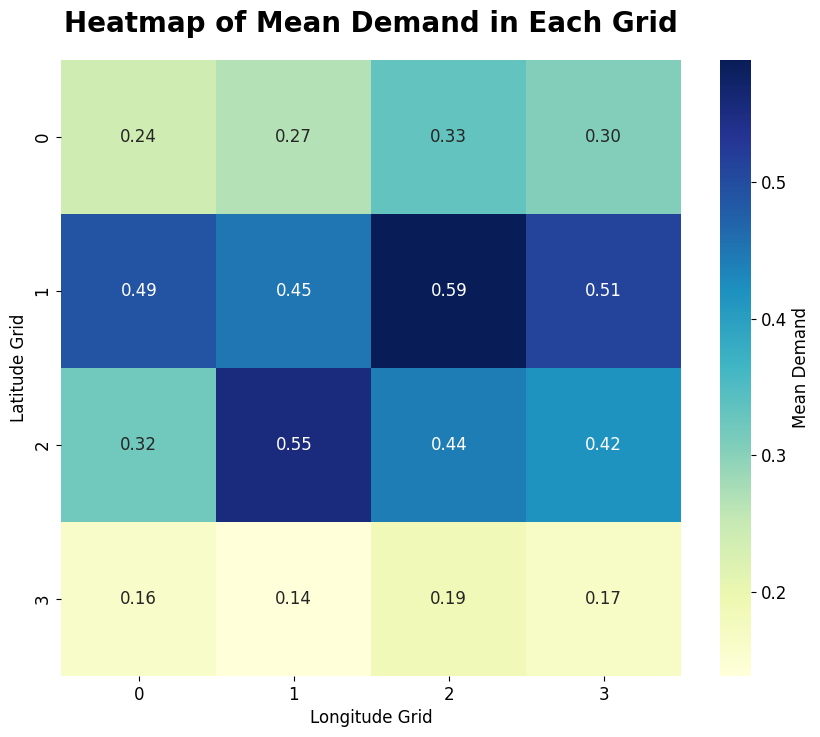

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

/home/asger/Documents/DTU/Speciale/multi_agent_reinforcement_learning/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asger/Documents/DTU/Speciale/multi_agent_reinforcement_learning/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


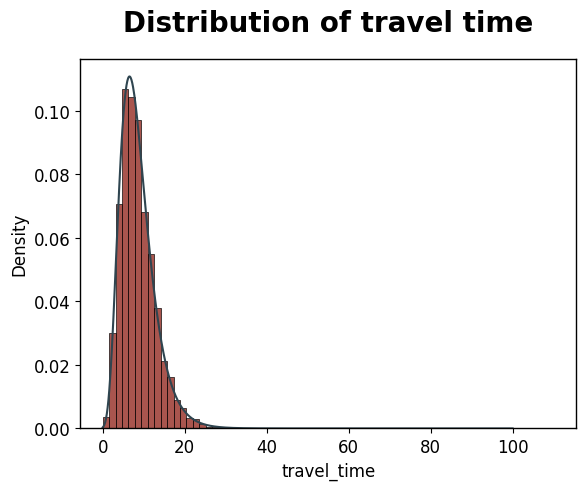

In [14]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

/home/asger/Documents/DTU/Speciale/multi_agent_reinforcement_learning/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/asger/Documents/DTU/Speciale/multi_agent_reinforcement_learning/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


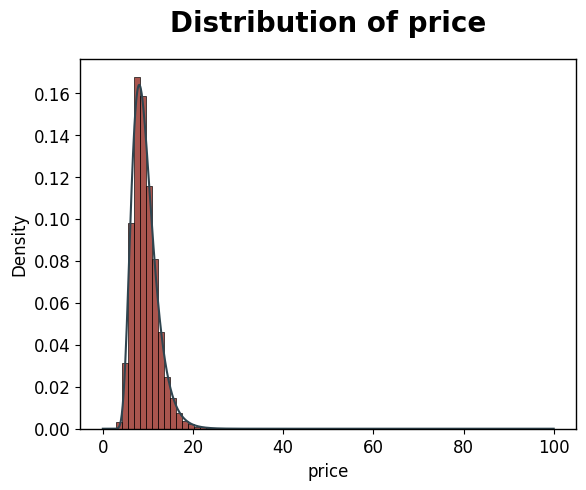

In [15]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [21]:
df.head()

,time_stamp,origin,destination,demand,travel_time,price
0,0,5,5,0.6,4.105556,6.5
1,1,5,5,0.6,4.105556,6.5
2,2,5,5,0.6,4.105556,6.5
3,3,5,5,0.6,4.105556,6.5
4,4,5,5,0.6,4.105556,6.5


In [109]:
pred_df = df.copy()

In [151]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [152]:
glm_model = smf.glm(formula="log_price ~ travel_time + demand", data=pred_df, family=sm.families.Gaussian())

In [153]:
fitted_glm = glm_model.fit()

In [154]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              log_price   No. Observations:               281760
Model:                            GLM   Df Residuals:                   281757
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                        0.023548
Method:                          IRLS   Log-Likelihood:             1.2832e+05
Date:                Mon, 25 Sep 2023   Deviance:                       6634.8
Time:                        12:14:54   Pearson chi2:                 6.63e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9211
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.7377      0.001   2430.063      0.000       1.736       1.739
travel_time     0.0554   6.62e-05    836.216      0.000       0.055       0.056
demand         -0.0505      0.001    -65.924      0.000      -0.052      -0.049
===============================================================================
"""

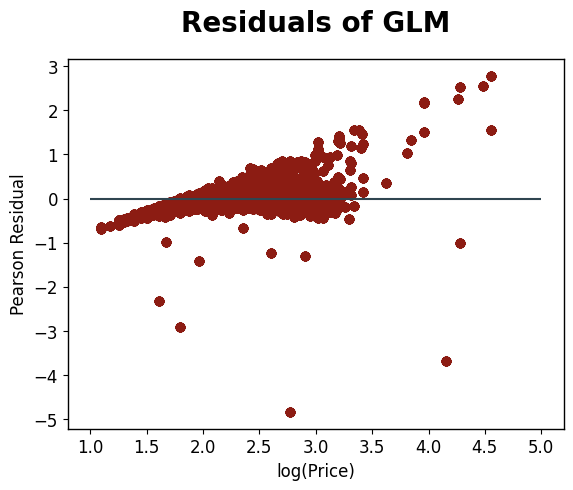

In [162]:
plt.scatter(pred_df["log_price"], fitted_glm.resid_pearson)
plt.hlines(y=0, xmin=1, xmax=5, color="#2F4550")
plt.xlabel("log(Price)")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()